In [29]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [30]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 50
NOISE_DIM = 100
NUM_CLASSES = 10

In [31]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 127.5 - 1.0
x_train = x_train.reshape(-1, 784)

y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)

dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
)

In [32]:
def build_generator(noise_dim, num_classes):
    noise = layers.Input(shape=(noise_dim,))
    label = layers.Input(shape=(num_classes,))

    x = layers.Concatenate()([noise, label])
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Dense(784, activation="tanh")(x)  # tanh for [-1, 1] range

    return tf.keras.Model([noise, label], x, name="generator")

In [33]:
def build_discriminator(input_dim, num_classes):
    data_input = layers.Input(shape=(input_dim,), name="image_input")
    label_input = layers.Input(shape=(num_classes,), name="label_input")

    combined = layers.Concatenate()([data_input, label_input])
    
    x = layers.Dense(512)(combined)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    logits = layers.Dense(1)(x)  # NO sigmoid - using from_logits=True

    model = tf.keras.Model(
        inputs=[data_input, label_input],
        outputs=logits,
        name="discriminator"
    )

    return model

In [34]:
generator = build_generator(NOISE_DIM, NUM_CLASSES)
discriminator = build_discriminator(784, NUM_CLASSES)

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Balanced learning rates
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [35]:
def generator_loss(fake_logits):
    return loss_fn(tf.ones_like(fake_logits), fake_logits)

def discriminator_loss(real_logits, fake_logits):
    real_labels = tf.ones_like(real_logits) * 0.9  # label smoothing
    fake_labels = tf.zeros_like(fake_logits)

    real_loss = loss_fn(real_labels, real_logits)
    fake_loss = loss_fn(fake_labels, fake_logits)
    return real_loss + fake_loss

In [36]:
@tf.function
def train_step(images, labels):
    # Train discriminator
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_logits = discriminator([images, labels], training=True)
        fake_logits = discriminator([generated_images, labels], training=True)

        disc_loss = discriminator_loss(real_logits, fake_logits)

    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    # Train generator (with fresh noise)
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    
    with tf.GradientTape() as gen_tape:
        generated_images = generator([noise, labels], training=True)
        fake_logits = discriminator([generated_images, labels], training=True)
        gen_loss = generator_loss(fake_logits)

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))

    return gen_loss, disc_loss

In [37]:
for epoch in range(EPOCHS):
    for image_batch, label_batch in dataset:
        g_loss, d_loss = train_step(image_batch, label_batch)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch+1}/{EPOCHS} | "
            f"G Loss: {g_loss:.4f} | D Loss: {d_loss:.4f}"
        )


Epoch 5/50 | G Loss: 1.0235 | D Loss: 1.2131
Epoch 10/50 | G Loss: 0.9417 | D Loss: 1.2867
Epoch 15/50 | G Loss: 1.0716 | D Loss: 1.2641
Epoch 20/50 | G Loss: 0.8964 | D Loss: 1.3243


KeyboardInterrupt: 

In [38]:
def generate_digit(digit, n=16):
    noise = tf.random.normal([n, NOISE_DIM])
    labels = tf.one_hot([digit] * n, NUM_CLASSES)

    images = generator([noise, labels], training=False)
    images = images.numpy().reshape(n, 28, 28)
    
    # Denormalize from [-1, 1] to [0, 1]
    images = (images + 1) / 2

    plt.figure(figsize=(4, 4))
    for i in range(n):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Generated Digit: {digit}")
    plt.tight_layout()
    plt.show()

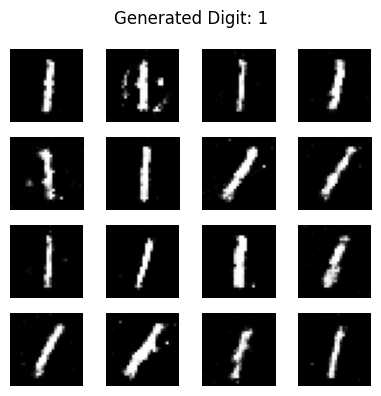

In [39]:
generate_digit(1)